In [94]:
!pip install seaborn

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##CSF Internship Data Analysis Assessment
### Deborah Atsagbede

*6th June, 2025*

## Introduction

Welcome to my exploration of a Cheese dataset! In this project, I explored the Canadian Cheese Directory and merged it with historical temperature data across provinces to investigate potential patterns between climate and cheese characteristics, such as moisture content. I used Python and its libraries to clean, transform, and analyze the data — demonstrating my ability to work with messy real-world datasets, perform exploratory analysis, and create insightful visualizations. This project reflects both my technical skill set and my curiosity in uncovering how environmental factors may influence regional food production.

Datasets Used:  
- [Canadian Cheese Directory](https://www.kaggle.com/datasets/noahjanes/canadian-cheese-directory/data)  
- [Canadian Weather Data](https://www.kaggle.com/datasets/sarahquesnelle/canada-data)


## Table of Content
1. Data Acquisition and Cleaning
2. Data Visualization
3. Conclusion

## Data Acquisition and Cleaning

In [104]:
cheese_df = pd.read_csv("cheese_data.csv")
cheese_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [97]:
weather_df = pd.read_csv("Canada_Temperature_Data.csv")
weather_df.head()

,Year,Month,Stn_Name,Prov,Tm,S,P
0,1917,1,COWICHAN,BC,1.3,54.6,114.7
1,1917,1,COWICHAN BAY CHERRY POINT,BC,1.3,24.1,87.7
2,1917,1,JAMES ISLAND,BC,3.3,25.3,95.8
3,1917,1,METCHOSIN,BC,2.2,46.9,156.4
4,1917,1,MILNES LANDING,BC,2.4,16.5,127.8


In [98]:
# drop any empty rows in the Temperature column
weather_df.dropna(subset = ["Tm"],axis=0, inplace=True)

In [100]:
avg_temp_by_prov = weather_df.groupby("Prov")["Tm"].mean().reset_index()
avg_temp_by_prov.columns = ["Province", "AvgTemp"]
avg_temp_by_prov.head()

,Province,AvgTemp
0,AB,4.443528
1,BC,6.848785
2,MB,1.996501
3,NB,4.743894
4,NL,3.661499


To make the weather dataset suitable for analysis, I removed rows that were missing temperature values and found the average temperature for each province (I will only be working with these two columns).


In [105]:
#filtering out the columns we need for analysis
cheese_df = cheese_df[["ManufacturerProvCode", "MoisturePercent", "FatLevel", "Organic"]]
cheese_df.columns = ["Province", "MoisturePercent", "FatLevel", "Organic"]
cheese_df.head()

,Province,MoisturePercent,FatLevel,Organic
0,NB,47.0,lower fat,0
1,NB,47.9,lower fat,0
2,ON,54.0,lower fat,0
3,NB,47.0,lower fat,0
4,NB,49.4,lower fat,1


In [106]:
cheese_df['Province'].value_counts()

,count
Province,
QC,796
ON,115
BC,65
NB,27
AB,13
MB,11
NS,10
NL,2
PE,2


The output above shows that the number of cheese entries is heavily skewed towards certain provinces — with Quebec (QC) having the most by far. This imbalance can introduce bias and inaccuracy in our analysis.




In [107]:
fat_mapping = {
    'lower fat': 0,
    'higher fat': 1
}
cheese_df['FatLevelNum'] = cheese_df['FatLevel'].map(fat_mapping)


In [108]:
# Group by province
cheese_avg = cheese_df.groupby('Province').agg({
    'MoisturePercent': 'mean',
    'FatLevelNum': 'mean',
    'Organic': 'mean'
}).reset_index()

# Merge with weather avg per province
combined = pd.merge(cheese_avg, avg_temp_by_prov, on='Province')


In [111]:
combined_df = pd.merge(cheese_avg, avg_temp_by_prov, on="Province", how="inner")
combined_df.head()

,Province,MoisturePercent,FatLevelNum,Organic,AvgTemp
0,AB,42.346154,0.461538,0.000000,4.443528
1,BC,41.490164,0.630769,0.307692,6.848785
2,MB,41.545455,0.090909,0.090909,1.996501
3,NB,49.603704,0.000000,0.111111,4.743894
4,NL,39.500000,0.500000,0.000000,3.661499


To enable meaningful comparisons across provinces and assess relationships among numerical columns, I converted the FatLevel column into a binary numeric format (FatLevelNum). I then calculated the average moisture percentage, organic percentage, and fat level per province, storing the results in the cheese_avg DataFrame. This was subsequently merged with the avg_weather DataFrame to combine cheese and weather data. These aggregations help smooth out the uneven distribution of entries across provinces and enable normalized, province-level analysis of cheese characteristics.


##Data Visualization

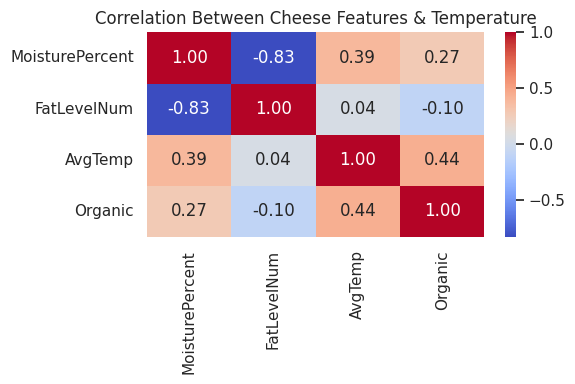

In [112]:
# Select relevant numeric features
numeric_cols = ['MoisturePercent', 'FatLevelNum', 'AvgTemp', 'Organic']
corr_matrix = combined_df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Cheese Features & Temperature')
plt.tight_layout()
plt.show()


From the correlation heatmap above, there is a strong negative correlation (-0.83) between fat level and moisture percentage, suggesting that higher-fat cheeses tend to have lower moisture content. Additionally, average temperature shows a moderate positive correlation with both organic cheeses (0.44) and moisture percentage (0.39).

While all of these are interesting relationships, I will explore the average temperature vs. moisture percentage correlation further in the next visualization, as it directly aligns with the goal of understanding how climate may influence cheese characteristics across Canadian provinces.

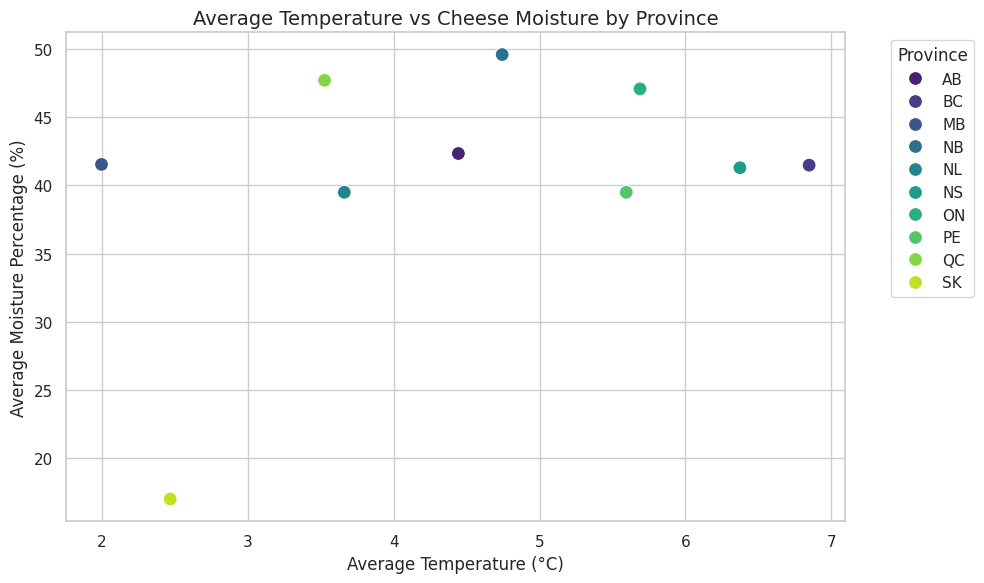

In [113]:
sns.set(style="whitegrid")

# Scatterplot: Avg Temperature vs Moisture Percent, colored by Province
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=combined_df,
    x="AvgTemp",
    y="MoisturePercent",
    hue="Province",
    palette="viridis",
    s=100
)

plt.title("Average Temperature vs Cheese Moisture by Province", fontsize=14)
plt.xlabel("Average Temperature (°C)", fontsize=12)
plt.ylabel("Average Moisture Percentage (%)", fontsize=12)
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The scatterplot above shows the relationship between average provincial temperature and average cheese moisture content.
New Brunswick (NB) stands out with the highest average moisture (49%) at a moderate temperature (4.7°C), followed by Quebec (QC) and Ontario (ON).
Interestingly, Saskatchewan (SK) produces cheeses with the lowest moisture levels (below 20%) despite having a slightly warmer average temperature (2.5°C) than Manitoba (MB) (2.0°C), which has higher moisture.

This suggests that while temperature may have some influence, other factors like cheese-making traditions, or consumer preferences may play a larger role in moisture content.



#Conclusion

This project explored the relationship between average provincial temperature and cheese characteristics in Canada, using two distinct datasets. After cleaning, transforming, and aggregating the data, I uncovered some interesting insights. Provinces with higher temperatures, like New Brunswick and Ontario, tend to produce cheeses with higher moisture content, while cooler provinces such as Saskatchewan and Manitoba show lower average moisture levels.

However, correlation does not imply causation. While temperature showed moderate correlation with moisture and organic cheese production, other factors such as regional cheese-making traditions, access to pasteurization methods, and milk types likely contribute significantly to the observed patterns.

This analysis demonstrates not only my technical skills in data cleaning, integration, and visualization, but also my ability to draw meaningful, business-relevant insights from complex datasets. It reflects my curiosity and analytical thinking—essential qualities I would bring to your data-driven team.

